**Business Problem**

New users on Airbnb can book a place to stay in 34,000+ cities across 190+ countries. By accurately predicting where a new user will book their first travel experience, Airbnb can share more personalized content with their community, decrease the average time to first booking, and better forecast demand.

**Data Description**

In this challenge, you are given a list of users along with their demographics, web session records, and some summary statistics. You are asked to predict which country a new user's first booking destination will be. All the users in this dataset are from the USA.

There are 12 possible outcomes of the destination country: 'US', 'FR', 'CA', 'GB', 'ES', 'IT', 'PT', 'NL','DE', 'AU', 'NDF' (no destination found), and 'other'. Please note that 'NDF' is different from 'other' because 'other' means there was a booking, but is to a country not included in the list, while 'NDF' means there wasn't a booking.

The training and test sets are split by dates. In the test set, you will predict all the new users with first activities after 7/1/2014 (note: this is updated on 12/5/15 when the competition restarted). In the sessions dataset, the data only dates back to 1/1/2014, while the users dataset dates back to 2010. 




**Solution**
1. Predict and load in a database, use data visualization to see results

2. API: 
    * Input: id and customer features
    * Output: id + predict + probability

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os

from scipy import stats as ss
from sklearn import model_selection as ms
from sklearn import preprocessing as pp
from sklearn import metrics 

from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from imblearn.combine import SMOTETomek

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

from keras import models as ml
from keras import layers as l

from scikitplot import metrics as mt

import random
from matplotlib import pyplot as plt
pd.set_option('mode.chained_assignment', None)


def save_nn_model(model_name_h5):

    ohe = pp.OneHotEncoder()
    y_train_nn = ohe.fit_transform(y_train.values.reshape(-1,1)).toarray()
    y_test_nn = ohe.fit_transform(y_test.values.reshape(-1,1)).toarray()

    #model definition
    from tensorflow.keras.callbacks import EarlyStopping
    from tensorflow.keras.models import load_model
    
    model_path = f'../models/{model_name_h5}'
    if os.path.exists(model_path):
        model = load_model(model_path)

    else:
        # Definindo o Early Stopping
        early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

        model = ml.Sequential()
        model.add(l.Dense(256, input_dim=X_train.shape[1] , activation='relu'))
        model.add(l.Dropout(0.2))  # Adicionando camada de dropout com taxa de 20%
        model.add(l.Dense(12, activation='softmax'))

        #model compile
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        #train model
        model.fit(X_train, y_train_nn, epochs=50, validation_data=(X_test, y_test_nn), callbacks=[early_stopping])

        model.save(model_path)

def num_stats(df):
    num_attributes = df.select_dtypes(['int64', 'float64'])

    #central tendency
    mean = pd.DataFrame(num_attributes.apply(np.mean)).T
    median = pd.DataFrame(num_attributes.apply(np.mean)).T

    #dispersion
    min_ = pd.DataFrame(num_attributes.apply(min)).T
    max_ = pd.DataFrame(num_attributes.apply(max)).T
    range_ = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
    skew  = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
    kurtosis = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
    std = pd.DataFrame(num_attributes.apply(np.std)).T

    m_numeric = pd.concat([min_, max_, range_, mean, median, std, skew, kurtosis]).T.reset_index()

    m_numeric.columns = ['attributes','min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
    return m_numeric

def cramer_v(x,y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / min(kcorr-1, rcorr-1))

def load_data():
    df_raw = pd.read_csv('../data/train_users_2.csv', low_memory=True)
    df_sessions = pd.read_csv('../data/sessions.csv')
    return df_raw, df_sessions

def transform_data(df, df_sessions):
    #==================Training================
    #date_first_booking
    date_first_booking_max = pd.to_datetime(df['date_first_booking']).max().strftime('%Y-%m-%d')
    df['date_first_booking']=df['date_first_booking'].fillna(date_first_booking_max)

    #age
    age_mean = df['age'].mean()
    df['age'] = df['age'].fillna(age_mean)

    # first_affiliate_tracked
    df['first_affiliate_tracked'].dropna(inplace=True)

    #==================Sessions==============
    df_sessions.dropna(inplace = True)
    
    #date_account_created
    df['date_account_created'] = pd.to_datetime(df['date_account_created'])

    #timestamp_first_active
    df['timestamp_first_active'] = pd.to_datetime(df['timestamp_first_active'], format='%Y%m%d%H%M%S')
    # date_first_booking
    df['date_first_booking'] = pd.to_datetime(df['date_first_booking'])
    #age
    df['age'] = df['age'].astype('int64')
    
    #Filter
    df = df[(df['age']>15) & (df['age']<100)]
    
    return df, df_sessions

def feature_engineering(df, df_sessions):
    
    #time between first booking and first active
    df['first_active'] = pd.to_datetime(df['timestamp_first_active'].dt.strftime('%Y-%m-%d'))
    df['days_from_active_to_booking'] = (df['date_first_booking'] - df['first_active']).dt.days

    #time between first booking and account created
    df['days_from_account_created_to_booking'] = (df['date_first_booking'] - df['date_account_created']).dt.days

    #time between account created and first active
    df['days_from_active_to_account_created'] = (df['date_account_created'] - df['first_active']).dt.days

    #year  of first active
    df['year_first_active'] = df['first_active'].dt.year

    #month of first active
    df['month_first_active'] = df['first_active'].dt.month

    #day of first active
    df['day_first_active'] = df['first_active'].dt.day

    #day of week of first active
    df['day_of_week_first_active'] = df['first_active'].dt.dayofweek

    #week of year of first active
    df['week_of_year_first_active'] = df['first_active'].dt.isocalendar().week


    #year  of first booking
    df['year_first_booking'] = df['date_first_booking'].dt.year

    #month of first booking
    df['month_first_booking'] = df['date_first_booking'].dt.month

    #day of first booking
    df['day_first_booking'] = df['date_first_booking'].dt.day

    #day of week of first booking
    df['day_of_week_first_booking'] = df['date_first_booking'].dt.dayofweek

    #week of year of first booking
    df['week_of_year_first_booking'] = df['date_first_booking'].dt.isocalendar().week


    #year  of account created
    df['year_account_created'] = df['date_account_created'].dt.year

    #month of account created
    df['month_account_created'] = df['date_account_created'].dt.month

    #day of account created
    df['day_account_created'] = df['date_account_created'].dt.day

    #day of week of account created
    df['day_of_week_account_created'] = df['date_account_created'].dt.dayofweek

    #week of year of account created
    df['week_of_year_account_created'] = df['date_account_created'].dt.isocalendar().week

    # n_clicks
    n_clicks = df_sessions[df_sessions['action_type']=='click'].groupby('user_id').agg(n_clicks = ('user_id', 'count')).reset_index()
    df = pd.merge(df, n_clicks.rename(columns = {'user_id' : 'id'}), on ='id', how='left')
    df['n_clicks'].fillna(0, inplace=True)

    n_reviews = df_sessions[df_sessions['action']=='reviews'].groupby('user_id').agg(n_reviews = ('user_id', 'count')).reset_index()
    df = pd.merge(df, n_reviews.rename(columns = {'user_id' : 'id'}), on ='id', how='left')
    df['n_reviews'].fillna(0, inplace=True)
    
    return df

def data_preprocessing(df):
    #dummy variable - signup_method
#     dummy = pd.get_dummies(df['signup_method'])
#     df = pd.concat([df, dummy], axis=1)

    # language to binary, either is english or not
    df['language_en'] = np.where(df['language']=='en', 1, 0)

    # signup to binary, either is web or not
    df['signup_on_web'] = np.where(df['signup_app']== 'Web', 1, 0)

    # first_affiliate_tracked to binary, either is tracked or not
    df['tracked'] = np.where(df['first_affiliate_tracked']=='untracked', 0, 1)

    #binary features from first_device_type
    df['first_device_apple'] = np.where(df['first_device_type'].isin(['Mac Desktop', 'iPhone', 'iPad']), 1 ,0)
    df['first_device_desktop'] = np.where(df['first_device_type'].isin(['Mac Desktop', 'Desktop', 'Windows Desktop']), 1, 0)

    # frequency encoding
    affiliate_channel_frequency_encoding = df['affiliate_channel'].value_counts(normalize=True)
    df['affiliate_channel'] = df['affiliate_channel'].map(affiliate_channel_frequency_encoding)

    affiliate_provider_frequency_encoding = df['affiliate_provider'].value_counts(normalize=True)
    df['affiliate_provider'] = df['affiliate_provider'].map(affiliate_provider_frequency_encoding)

    first_browser_frequency_encoding = df['first_browser'].value_counts(normalize=True)
    df['first_browser'] = df['first_browser'].map(first_browser_frequency_encoding)
    
    # Rescaling
    columns_to_rescale = [
    "age",
    "signup_flow",
    "n_reviews",
    "n_clicks"
    ]

    scaler = pp.MinMaxScaler()

    df[columns_to_rescale] = scaler.fit_transform(df[columns_to_rescale])
    
    # temporal columns 
    temporal_columns = ["days_from_active_to_booking",
    "days_from_account_created_to_booking",
    "days_from_active_to_account_created",
    "year_first_active",
    "month_first_active",
    "day_first_active",
    "day_of_week_first_active",
    "week_of_year_first_active",
    "year_first_booking",
    "month_first_booking",
    "day_first_booking",
    "day_of_week_first_booking",
    "week_of_year_first_booking",
    "year_account_created",
    "month_account_created",
    "day_account_created",
    "day_of_week_account_created",
    "week_of_year_account_created"]

     # month_account_created
    df['month_account_created_sin'] = df['month_account_created'].apply( lambda x: np.sin( x * (2*np.pi/12 ) ) )
    df['month_account_created_cos'] = df['month_account_created'].apply( lambda x: np.cos( x * (2*np.pi/12 ) ) )

    # week_account_created
    df['week_account_created_sin'] = df['week_of_year_account_created'].apply( lambda x: np.sin( x * (2*np.pi/52 ) ) )
    df['week_account_created_cos'] = df['week_of_year_account_created'].apply( lambda x: np.cos( x * (2*np.pi/52 ) ) )

    # day_account_created
    df['day_account_created_sin'] = df['day_account_created'].apply( lambda x: np.sin( x * (2*np.pi/30 ) ) )
    df['day_account_created_cos'] = df['day_account_created'].apply( lambda x: np.cos( x * (2*np.pi/30 ) ) )

    # day_of_week_account_created
    df['day_of_week_account_created_sin'] = df['day_of_week_account_created'].apply( lambda x: np.sin( x * (2*np.pi/7 ) ) )
    df['day_of_week_account_created_cos'] = df['day_of_week_account_created'].apply( lambda x: np.cos( x * (2*np.pi/7 ) ) )

    # month_first_booking
    df['month_first_booking_sin'] = df['month_first_booking'].apply( lambda x: np.sin( x * (2*np.pi/12 ) ) )
    df['month_first_booking_cos'] = df['month_first_booking'].apply( lambda x: np.cos( x * (2*np.pi/12 ) ) )

    # day_first_booking
    df['day_first_booking_sin'] = df['day_first_booking'].apply( lambda x: np.sin( x * (2*np.pi/30 ) ) )
    df['day_first_booking_cos'] = df['day_first_booking'].apply( lambda x: np.cos( x * (2*np.pi/30 ) ) )

    # day_of_week_first_booking
    df['day_of_week_first_booking_sin'] = df['day_of_week_first_booking'].apply( lambda x: np.sin( x * (2*np.pi/7 ) ) )
    df['day_of_week_first_booking_cos'] = df['day_of_week_first_booking'].apply( lambda x: np.cos( x * (2*np.pi/7 ) ) )

    df.drop(temporal_columns, axis=1, inplace=True)
    
    
    cols_drop = [ 'gender', 'signup_method', 'language', 'first_affiliate_tracked',
           'signup_app', 'first_device_type','date_account_created', 'timestamp_first_active',
                 'date_first_booking', 'first_active'] #original dates
    df = df.drop(cols_drop, axis=1)
    return df

def balance_data(X_imb, y_imb):
    
    majority_value = y.value_counts()[0]

    # Calcular os pesos de classe inversamente proporcionais à frequência
    class_weights = {'NDF': majority_value*1,
                     'US': int(majority_value*0.5),
                     'other': int(majority_value*0.18),
                     'FR': int(majority_value*0.15) ,
                     'IT': int(majority_value*0.13),
                     'GB': int(majority_value*0.13),
                     'ES': int(majority_value*0.13),
                     'CA': int(majority_value*0.13),
                     'DE': int(majority_value*0.13),
                     'NL': int(majority_value*0.09),
                     'AU': int(majority_value*0.09),
                     'PT': int(majority_value*0.09)
                    }

    # Instanciar o SMOTE com os pesos de classe definidos
    smote = BorderlineSMOTE(sampling_strategy=class_weights)

    # Aplicar o resampling usando o SMOTE
    X_resampled, y_resampled = smote.fit_resample(X, y)

    return X_resampled, y_resampled

def feature_importance(X,y):
    X_train, X_test, y_train, y_test = ms.train_test_split(X,y,test_size=0.2, random_state=32)

    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    importances = model.feature_importances_  # Obtendo as importâncias das features
    feature_names = list(df.columns) # Obtendo os nomes das features

    feature_importances = [(feature, importance) for feature, importance in zip(feature_names, importances)]
    feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)

    sorted_features = [feature for feature, importance in feature_importances]
    sorted_importances = [importance for feature, importance in feature_importances]

    plt.figure(figsize=(10, 6))
    plt.bar(range(len(sorted_importances)), sorted_importances, align='center')
    plt.xticks(range(len(sorted_features)), sorted_features, rotation='vertical')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()

def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Converter classes categóricas para valores numéricos
    label_encoder = pp.LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    
    model.fit(X_train, y_train_encoded)
    yhat_encoded = model.predict(X_test)
    
    # Converter previsões numéricas de volta para a forma original
    yhat = label_encoder.inverse_transform(yhat_encoded)
    
    # Accuracy
    acc_random = metrics.accuracy_score(y_test, yhat)
    print(f'Accuracy score: {acc_random:.3f}')
    
    # Balanced accuracy
    balanced_acc_random = metrics.balanced_accuracy_score(y_test, yhat)
    print(f'Balanced accuracy score: {balanced_acc_random:.3f}')
    
    mt.plot_confusion_matrix(y_test, yhat, normalize=False, figsize=(10, 10), labels=label_encoder.classes_);

def get_model_metrics(model_trained, X_test, y_test):
    
    yhat = model_trained.predict(X_test)
    
    #balanced accuracy
    balanced_acc= metrics.balanced_accuracy_score(y_test, yhat)
 
    kappa_acc = metrics.cohen_kappa_score(y_test, yhat)
    
    return balanced_acc, kappa_acc


def cv(model, num_folds, X, y):
    kfold = ms.StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
    balanced_acc_list = []
    kappa_list = []
    x_train, x_test, y_train, y_test = ms.train_test_split(X, y, train_size=0.8)
    i= 1
    for train_ix, val_ix in kfold.split(x_train, y_train):
        print('Fold number {}'.format(i))
        #get fold
        x_train_fold = x_train.iloc[train_ix]
        y_train_fold = y_train.iloc[train_ix]

        x_val_fold = x_train.iloc[val_ix]
        y_val_fold = y_train.iloc[val_ix]

        model.fit(x_train_fold, y_train_fold)
        print(f'{i}/{num_folds}')
        
        balanced_acc, kappa = get_model_metrics(model, x_test, y_test)
        balanced_acc_list.append(balanced_acc)
        kappa_list.append(kappa)
        i+=1
    
    print(f'Balanced Accuracy CV = {np.mean(balanced_acc_list)}')
    print(f'Kappa Score CV = {np.mean(kappa_list)}')

### Pipeline

In [2]:
df_raw, df_sessions = load_data()

In [3]:
# numerical statistics of each dataset
display(num_stats(df_raw))
display(num_stats(df_sessions))

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,timestamp_first_active,2.009032e+13,2.014063e+13,5.031119e+10,2.013085e+13,2.013085e+13,9.253695e+09,-0.861578,0.355882
1,age,NaN,NaN,2.013000e+03,4.966834e+01,4.966834e+01,1.556660e+02,12.422586,153.568929
2,signup_flow,0.000000e+00,2.500000e+01,2.500000e+01,3.267387e+00,3.267387e+00,7.637689e+00,2.234366,3.324444


,attributes,min,max,range,mean,median,std,skew,kurtosis
0,secs_elapsed,0.0,1799977.0,1799977.0,19405.810751,19405.810751,88884.238948,11.141939,154.748944


In [4]:
df, df_sessions = transform_data(df_raw, df_sessions)


In [5]:
df = feature_engineering(df, df_sessions)

In [6]:
df = data_preprocessing(df)

In [7]:
X = df.drop(['country_destination', 'id'], axis=1)
y = df['country_destination'].copy()

In [8]:
X_balanced, y_balanced = balance_data(X, y)

In [9]:
# split imbalanced and balanced
X_train_imb, X_test_imb, y_train_imb, y_test_imb = ms.train_test_split(X, y, train_size=0.8)

X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = ms.train_test_split(X_balanced, y_balanced, train_size=0.8)

### Feature importance

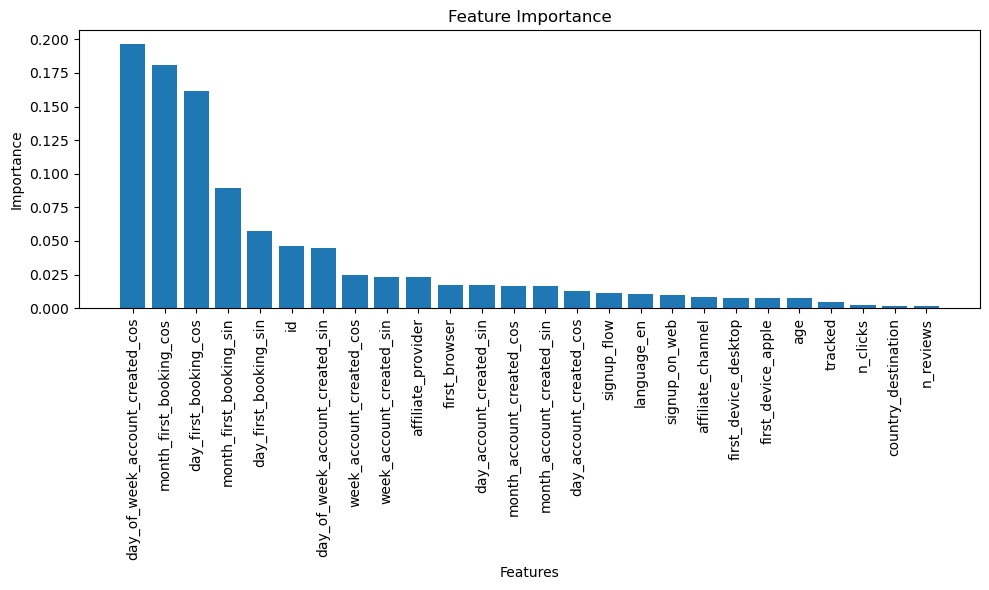

In [10]:
# imbalanced data
feature_importance(X,y)

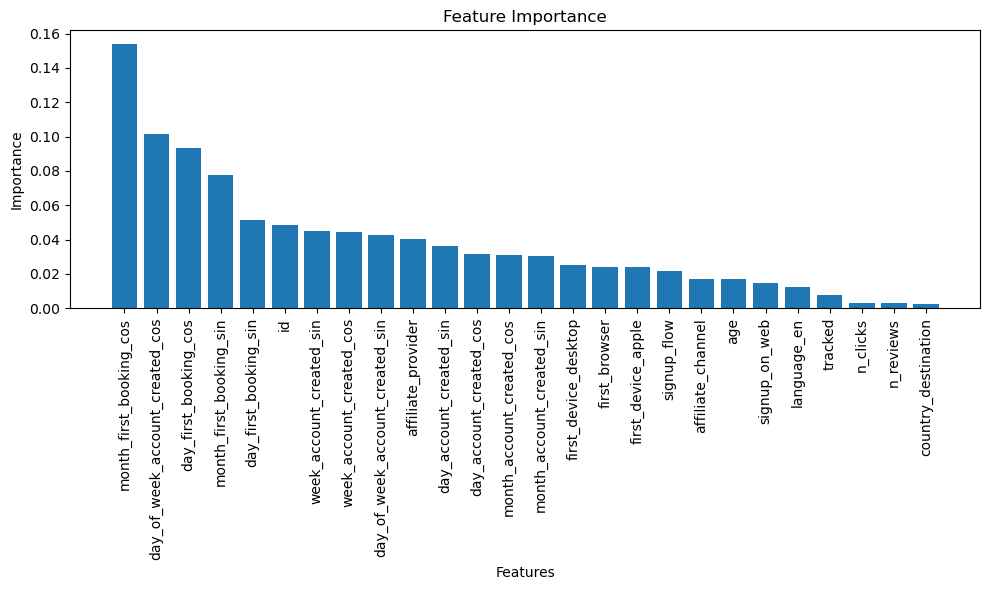

In [11]:
#balanced data
feature_importance(X_balanced, y_balanced)

In [12]:
# split data
X_train_imb, X_test_imb, y_train_imb, y_test_imb = ms.train_test_split(X, y, test_size=0.2, random_state=32)
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = ms.train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=32)


## 5.1. Baseline Model

In [16]:
import random

# wieghts to baseline Model
weights = df['country_destination'].value_counts(normalize=True).sort_index().tolist()
country_destination_list = df['country_destination'].drop_duplicates().sort_values().tolist()
k_num = y_test_imb.shape[0]
yhat_random = random.choices(population=country_destination_list, k=k_num, weights=weights)

Accuracy score: 0.431
Balanced accuracy score: 0.082
Kappa score: 0.004


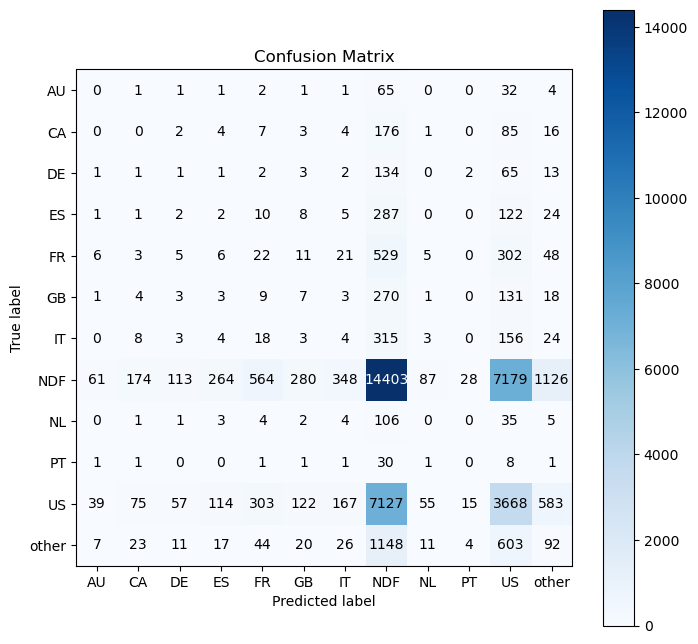

In [17]:
#Accuracy
acc_random = metrics.accuracy_score(y_test_imb, yhat_random)
print(f'Accuracy score: {acc_random:.3f}')

#Balanced accurace
balanced_acc_random = metrics.balanced_accuracy_score(y_test_imb, yhat_random)
print(f'Balanced accuracy score: {balanced_acc_random:.3f}')

#Kappa
kappa_random = metrics.cohen_kappa_score(y_test_imb, yhat_random)
print(f'Kappa score: {kappa_random:.3f}')

#Confusion Matrix
mt.plot_confusion_matrix(y_test_imb, yhat_random, normalize=False, figsize=(8,8));

### ExtraTreesClassifier

Accuracy score: 0.918
Balanced accuracy score: 0.889


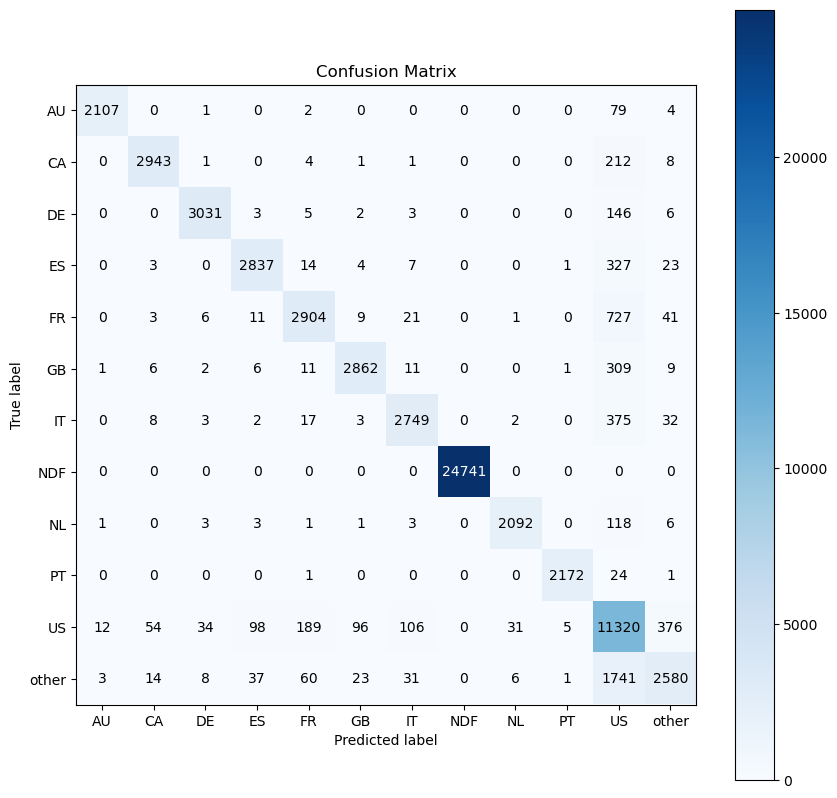

In [10]:
evaluate_model(ExtraTreesClassifier(), X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced)

### NN ( 2 camadas)

In [21]:
ohe = pp.OneHotEncoder()
y_train_nn = ohe.fit_transform(y_train_balanced.values.reshape(-1,1)).toarray()
y_test_nn = ohe.fit_transform(y_test_balanced.values.reshape(-1,1)).toarray()

#model definition
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

model_path = '../models/model3.h5'
if os.path.exists(model_path):
    model = load_model(model_path)
    
else:
    # Definindo o Early Stopping
    early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

    model = ml.Sequential()
    model.add(l.Dense(256, input_dim=X_train_balanced.shape[1] , activation='relu'))
    model.add(l.Dropout(0.2))  # Adicionando camada de dropout com taxa de 20%
    
    model.add(l.Dense(12, activation='softmax'))
    
    # Add more dense layers
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(64, activation='relu'))
    
    model.add(layers.Dense(12, activation='softmax'))

    #model compile
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    #train model
    model.fit(X_train_balanced, y_train_nn, epochs=100, validation_data=(X_test_balanced, y_test_nn), callbacks=[early_stopping])

    model.save(model_path)

Epoch 1/100
8488/8488 [==============================] - 21s 2ms/step - loss: 1.2627 - accuracy: 0.5811 - val_loss: 1.1215 - val_accuracy: 0.6218
Epoch 2/100
8488/8488 [==============================] - 26s 3ms/step - loss: 1.0965 - accuracy: 0.6290 - val_loss: 1.0151 - val_accuracy: 0.6572
Epoch 3/100
8488/8488 [==============================] - 25s 3ms/step - loss: 1.0287 - accuracy: 0.6519 - val_loss: 0.9665 - val_accuracy: 0.6723
Epoch 4/100
8488/8488 [==============================] - 23s 3ms/step - loss: 0.9921 - accuracy: 0.6635 - val_loss: 0.9224 - val_accuracy: 0.6868
Epoch 5/100
8488/8488 [==============================] - 23s 3ms/step - loss: 0.9675 - accuracy: 0.6713 - val_loss: 0.9035 - val_accuracy: 0.6909
Epoch 6/100
8488/8488 [==============================] - 24s 3ms/step - loss: 0.9501 - accuracy: 0.6768 - val_loss: 0.8931 - val_accuracy: 0.6931
Epoch 7/100
8488/8488 [==============================] - 25s 3ms/step - loss: 0.9377 - accuracy: 0.6798 - val_loss: 0.8928 -

Epoch 57/100
8488/8488 [==============================] - 25s 3ms/step - loss: 0.8249 - accuracy: 0.7195 - val_loss: 0.7676 - val_accuracy: 0.7404
Epoch 58/100
8488/8488 [==============================] - 29s 3ms/step - loss: 0.8251 - accuracy: 0.7192 - val_loss: 0.7669 - val_accuracy: 0.7396


2122/2122 [==============================] - 2s 829us/step
Accuracy score: 0.7393776049720909
Balanced accuracy score: 0.6104042755194962
Kappa score: 0.6709378851565194


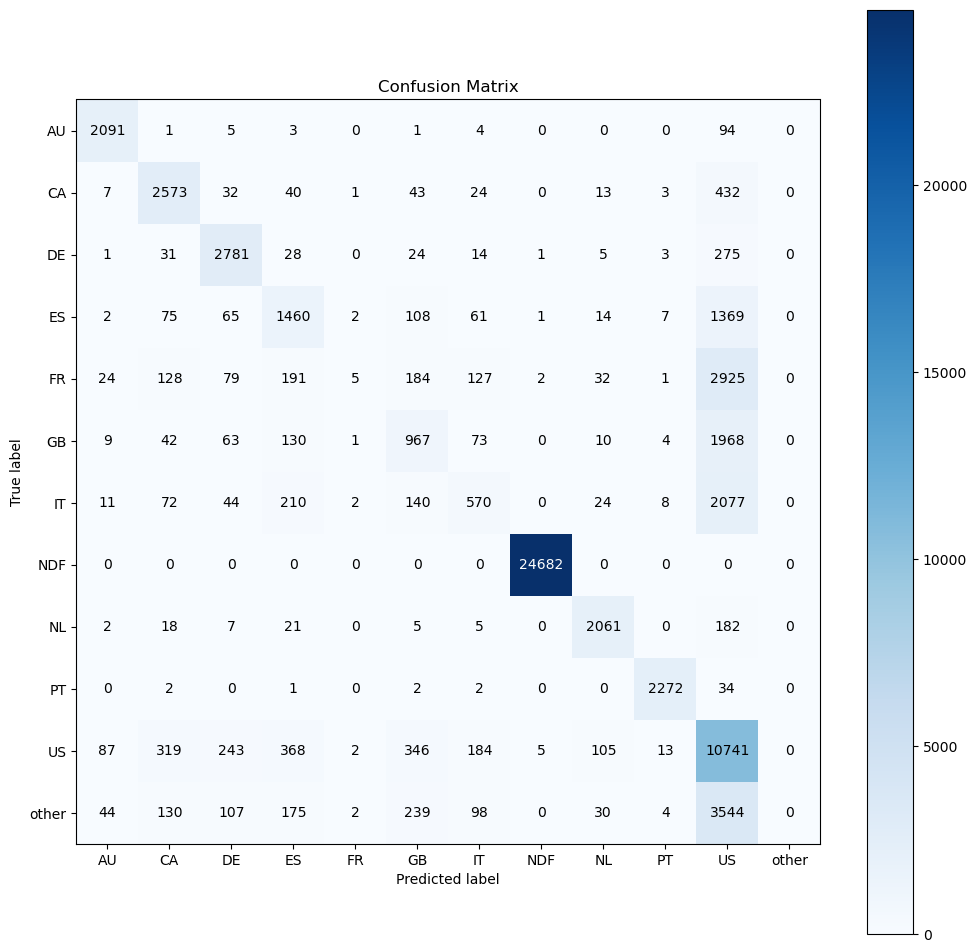

In [22]:
#prediction
pred_nn = model.predict(X_test_balanced)

#invert prediction
yhat_nn = ohe.inverse_transform(pred_nn)

#prediction prepare
y_test_nn = y_test_balanced.to_numpy()
yhat_nn = yhat_nn.reshape(1,-1)[0]

#Accuracy
acc_nn = metrics.accuracy_score(y_test_nn, yhat_nn)
print(f'Accuracy score: {acc_nn}')


#Balanced accurace
balanced_acc_nn = metrics.balanced_accuracy_score(y_test_nn, yhat_nn)
print(f'Balanced accuracy score: {balanced_acc_nn}')

#Kappa
kappa_nn = metrics.cohen_kappa_score(y_test_nn, yhat_nn)
print(f'Kappa score: {kappa_nn}')

#Confusion Matrix
mt.plot_confusion_matrix(y_test_nn, yhat_nn, normalize=False, figsize=(12,12));



### Cross validation - Balanced vs Imbalanced

In [13]:
cv(ExtraTreesClassifier(), 10, X, y)

Fold number 1
1/10
Fold number 2
2/10
Fold number 3
3/10
Fold number 4
4/10
Fold number 5
5/10
Fold number 6
6/10
Fold number 7
7/10
Fold number 8
8/10
Fold number 9
9/10
Fold number 10
10/10
Balanced Accuracy CV = 0.1683282707843502
Kappa Score CV = 0.747401586740158


In [14]:
cv(ExtraTreesClassifier(), 10, X_balanced, y_balanced)

Fold number 1
1/10
Fold number 2
2/10
Fold number 3
3/10
Fold number 4
4/10
Fold number 5
5/10
Fold number 6
6/10
Fold number 7
7/10
Fold number 8
8/10
Fold number 9
9/10
Fold number 10
10/10
Balanced Accuracy CV = 0.8861906697690483
Kappa Score CV = 0.8965223318758264
